# Landuse Classification with Pytorch Lightning
Pada notebook ini akan dibahas klasifikasi landuse menggunakan mobilenet v3 menggunakan PyTorch Lightning. Akan dilakukan beberapa data augmentation dengan ilmu image processing dari free course Bisa.ai

## 1. Preparation Data

Pertama - tama, install PyTorch Lightning terlebih dahulu

In [41]:
import warnings
warnings.filterwarnings('ignore')
!pip install -q kaggle pytorch-lightning

Agar memudahkan proses pelatihan, pengunduhan dataset sepenuhnya akan dilakukan di google colab. Dataset diambil dari kaggle melalui link berikut: https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification <br>
Penggunaan kaggle di google colab bisa disimak melalui tutorial berikut: https://www.kaggle.com/general/74235

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"achmadjaelani","key":"dd189eefc225838464d0d97aac573496"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d apollo2506/landuse-scene-classification
! unzip -q /content/landuse-scene-classification.zip


100% 1.98G/1.98G [00:12<00:00, 175MB/s]
100% 1.98G/1.98G [00:12<00:00, 169MB/s]


In [42]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

import torch

import matplotlib.pyplot as plt

import torch.nn.functional as F

from torchvision.models import mobilenet_v2 as mobilenet_v3_small

import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from torchmetrics import Accuracy

## 2. Preprocessing Data

Data Augmentation adalah proses augmentasi data dengan mengubah ciri gambar dengan tujuan agar data lebih beragam sehingga model neural network lebih *robust* dan general. <br>
Pada data augmentasi dibawah, penggunaan rotasi, vertical flip, horizontal flip digunakan.

In [79]:
class LandUseDataModule(pl.LightningDataModule):
  def __init__(self, batch_size=64):
    super().__init__()
    self.batch_size = batch_size

    # Augmentation Training Set
    self.augmentation = transforms.Compose([
      transforms.Resize(230),
      transforms.CenterCrop(224),
      transforms.RandomRotation((0, 180)),
      transforms.RandomVerticalFlip(),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # For training and validation data
    self.transformer = transforms.Compose([
      transforms.Resize(230),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    self.num_classes = 21

  def setup(self, stage=None):
    self.train_data = ImageFolder(
      "/content/images_train_test_val/train", 
      transform=self.augmentation,
    )
    self.val_data = ImageFolder(
      "/content/images_train_test_val/validation",
      transform=self.transformer
    )
    self.test_data = ImageFolder(
      "/content/images_train_test_val/test",
      transform=self.transformer
    )

  def train_dataloader(self):
    return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_data, batch_size=self.batch_size) 

  def test_dataloader(self):
    return DataLoader(self.test_data, batch_size=self.batch_size)

  def plot(self):
      trains = ImageFolder(
      "/content/images_train_test_val/train", 
      transform=self.augmentation,
      )
      classes = trains.classes
      data = DataLoader(trains, batch_size=self.batch_size, shuffle=True)
      feature, target = next(iter(data))
      fig, axes = plt.subplots(8, 8, figsize=(15, 15))
      for f, t, ax in zip(feature, target, axes.flatten()):
          ax.imshow(f.permute(1, 2, 0))
          ax.set_title(classes[t])
          ax.axis("off")

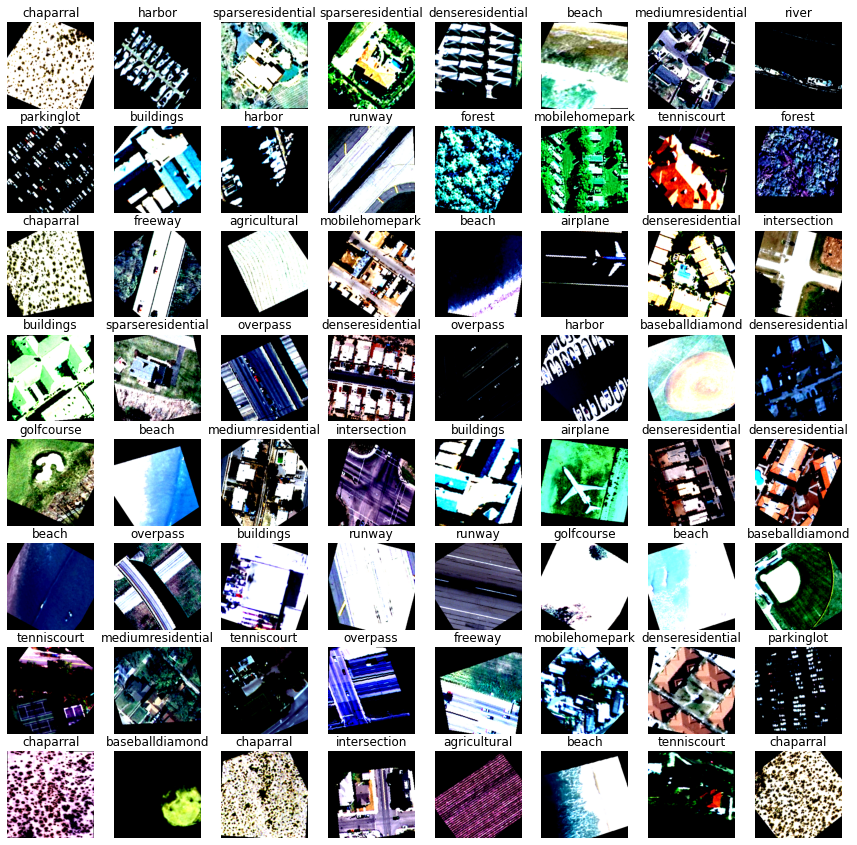

In [80]:
prep = LandUseDataModule()
prep.plot()

Membuat model *from scratch* mungkin mempunyai kelebihan tertentu. Namun menggunakan *state-of-the-art* model computer vision akan mempermudah proses training. Pada notebook ini, mobilenet v3 digunakan sebagai basis untuk melakukan *Transfer Learning*

In [81]:
class MobileNet(pl.LightningModule):
  def __init__(self, num_classes, learning_rate=1e-4, transfer=False):
    super().__init__()

    # log hyperparameters
    self.save_hyperparameters()
    self.learning_rate = learning_rate
    self.num_classes = num_classes
    self.transfer = transfer

    # transfer learning
    self.mnet = mobilenet_v3_small(pretrained=transfer)

    if self.transfer:
      for param in self.mnet.parameters():
        param.requires_grad = False
    else:
      for param in self.mnet.parameters():
        param.requires_grad = True 
    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, self.num_classes),
        nn.Sigmoid()
    )
    
    self.classifier = nn.Linear(1280, num_classes)
    self.criterion = nn.CrossEntropyLoss()
    self.accuracy = Accuracy()

  def forward(self, x):
      return self.mnet(x)

  def training_step(self, batch):
    x, y = batch
    output = self.forward(x)
    loss = self.criterion(output, y)
    acc = self.accuracy(output, y)

    self.log("train_loss", loss, on_step=True, logger=True)
    self.log("train_acc", acc, on_step=True, logger=True, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    output = self.forward(x)
    loss = self.criterion(output, y)
    acc = self.accuracy(output, y)

    self.log("val_loss", loss, on_epoch=True, logger=True)
    self.log("val_acc", acc, on_epoch=True, logger=True, prog_bar=True)
    return loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    output = self.forward(x)
    loss = self.criterion(output, y)
    acc = self.accuracy(output, y)

    self.log("test_loss", loss)
    self.log("test_acc", acc)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

## 3. Transfer Learning

In [82]:
dataloader = LandUseDataModule()
model = MobileNet(num_classes=21, transfer=True)
early_stopping = pl.callbacks.early_stopping.EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=False)
model_checkpoint = ModelCheckpoint(
    dirpath=None,
    monitor="val_acc",
    filename=f"best_model_wow",
    save_top_k=1,
    mode="max",
    every_n_epochs=1
)
trainer = pl.Trainer(callbacks=[early_stopping, model_checkpoint], accelerator="gpu", max_epochs=100, )
trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | mnet       | MobileNetV2      | 2.3 M 
1 | classifier | Linear           | 26.9 K
2 | criterion  | CrossEntropyLoss | 0     
3 | accuracy   | Accuracy         | 0     
------------------------------------------------
53.8 K    Trainable params
2.2 M     Non-trainable params
2.3 M     Total params
9.111     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## 4. Finetuning

In [85]:
model.transfer = False
model.learning_rate = 1e-5
trainer.fit(model, dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | mnet       | MobileNetV2      | 2.3 M 
1 | classifier | Linear           | 26.9 K
2 | criterion  | CrossEntropyLoss | 0     
3 | accuracy   | Accuracy         | 0     
------------------------------------------------
53.8 K    Trainable params
2.2 M     Non-trainable params
2.3 M     Total params
9.111     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

## 5. Testing model

In [88]:
loss = trainer.test(model, dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8590475916862488
        test_loss           2.2863168716430664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 2.2863168716430664, 'test_acc': 0.8590475916862488}]


Model memiliki akurasi 85% pada data testing